# REGRID // limited update of Jan - Dec 2022

In [1]:
import xarray as xr

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44165,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42483,Total threads: 1
Dashboard: /proxy/33985/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:42097,


In [4]:
update_data = xr.open_mfdataset('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/variables_native_grid/DS_nativeTgrid_2022_update.nc',parallel=True)

In [5]:
update_data

<xarray.Dataset>
Dimensions:        (time: 15, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time           (time) datetime64[ns] 2022-01-15 2022-02-15 ... 2023-03-15
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables:
    areat          (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time, ndepth_bounds) float32 dask.array<chunksize=(15, 2), meta=np.ndarray>
    latt_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(15, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(15, 1021, 1442, 4), meta=np.ndarray>
    hc300          (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    mld1           (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    sst            (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    temp100        (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    TimeStamp:    12/09/2018 08:38:02 -0000
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...
    production:   An IPSL model

# drop uneeded info

In [6]:
update_data = update_data.drop(['areat','deptht_bounds','latt_bounds','lont_bounds'])

In [7]:
update_data

<xarray.Dataset>
Dimensions:  (time: 15, y: 1021, x: 1442)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 2022-01-15 2022-02-15 ... 2023-03-15
Dimensions without coordinates: y, x
Data variables:
    hc300    (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    mld1     (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    sst      (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
    temp100  (time, y, x) float32 dask.array<chunksize=(15, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    TimeStamp:    12/09/2018 08:38:02 -0000
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...
    production:   An IPSL model

# what region are we looking at?

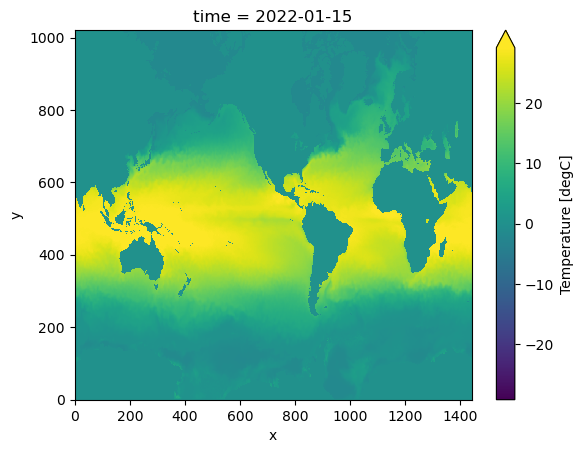

In [8]:
update_data.sst.isel(time=0).plot(cmap="viridis",robust=True)

# Insert land masked NaN's for all variables.
## BoM ACCESS-S2 mask file isn't available so use where values == exactly zero. Goal is to replace pure zero with NaN

In [9]:
update_data_masked = update_data.where(update_data != 0)

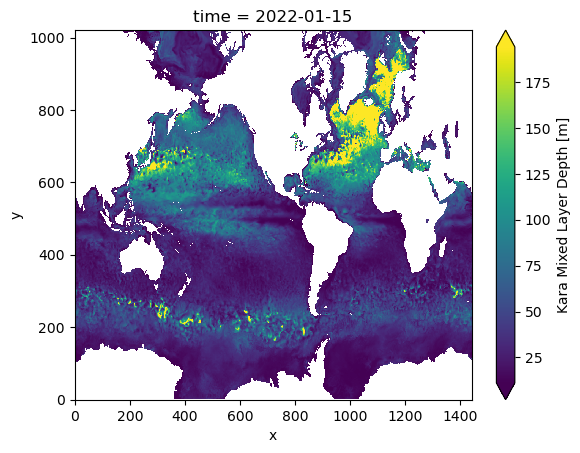

In [10]:
update_data_masked.mld1.isel(time=0).plot(cmap="viridis",robust=True)

# crop with padding as done in past workflow

# shift lon values

In [11]:
def extend_S2_lon_across180(real_lon):
    '''
    extend_S2_lon_across180
    Notes: ACCESS-S2 runs from left to right 72.75 to 73 through 180/-180. For this specific application we are trying to bridge the 180/-180 date
        line with increasing values.  This is simply to use a .where technique to slice the mulitdimensional coordinates over the Pacific.
    Returns: 
    Defaults:
    Author: Thomas Moore
    Date created: 21/02/2022
    Assumptions:
    Use:
    Limitations:
    '''
    return (real_lon % 360)

In [12]:
update_data_masked['lon'] = extend_S2_lon_across180(update_data_masked['lon']).compute()
update_data_masked['lat'] = update_data_masked.lat.compute()

# Crop dataset to ETBF bounds
## Use the `where` method to deal with multidimensional coordinates
#### See SHOYER's comments here > https://stackoverflow.com/questions/41818927/how-to-subset-data-using-multidimensional-coordinates-using-python-xarray

## approach will be to pad out beyond the needed coordinates to eliminate edge effects after regridding - we'll "crop out the cropped data" after regridding
### required coordinates are: "Region crop" at Lon : 100-240 & Lat negative 60 - 5 to assist in memory issues with laptops. 
#### Here use where : Lon = 90 - 270 & Lat = -70 - 20

In [13]:
update_data_masked_crop = update_data_masked.where((90 < update_data_masked.lon) & (update_data_masked.lon < 270)
         & (-70 < update_data_masked.lat) & (update_data_masked.lat < 20), drop=True)

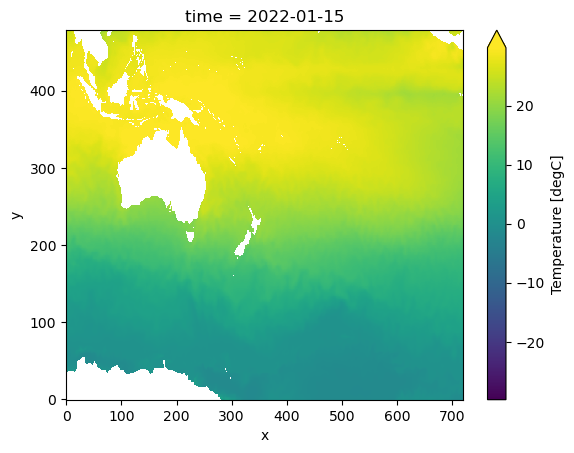

In [14]:
update_data_masked_crop.sst.isel(time=0).plot(cmap="viridis",robust=True)

# How big is this DS?

In [15]:
update_data_masked_crop.nbytes/1e9

0.085411568

# export

In [3]:
update_data_masked_crop.to_netcdf('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/variables_native_grid/DS_nativeTgrid_2022_update_masked_crop.nc')

NameError: name 'update_data_masked_crop' is not defined

# regrid

# Make 0.25degree land mask
uses https://github.com/toddkarin/global-land-mask <br>
which is based on elevation data here > https://www.ngdc.noaa.gov/mgg/topo/gltiles.html

In [16]:
from global_land_mask import globe
import numpy as np

# Lat/lon points to get
lat = np.linspace(-90,90,721)
lon = np.linspace(-180,179.75,1440)

# Make a grid
lon_grid, lat_grid = np.meshgrid(lon,lat)

# Get whether the points are on land.
z = globe.is_land(lat_grid, lon_grid)

In [17]:
land_mask = xr.DataArray(
   ...:     z,
   ...:     coords={
   ...:         "lat": lat,
   ...:         "lon": lon,
   ...:     },
   ...:     dims=["lat", "lon"],
   ...:     )

land_mask = land_mask.astype(int)
land_mask

<xarray.DataArray (lat: 721, lon: 1440)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

(100.0, 180.0)

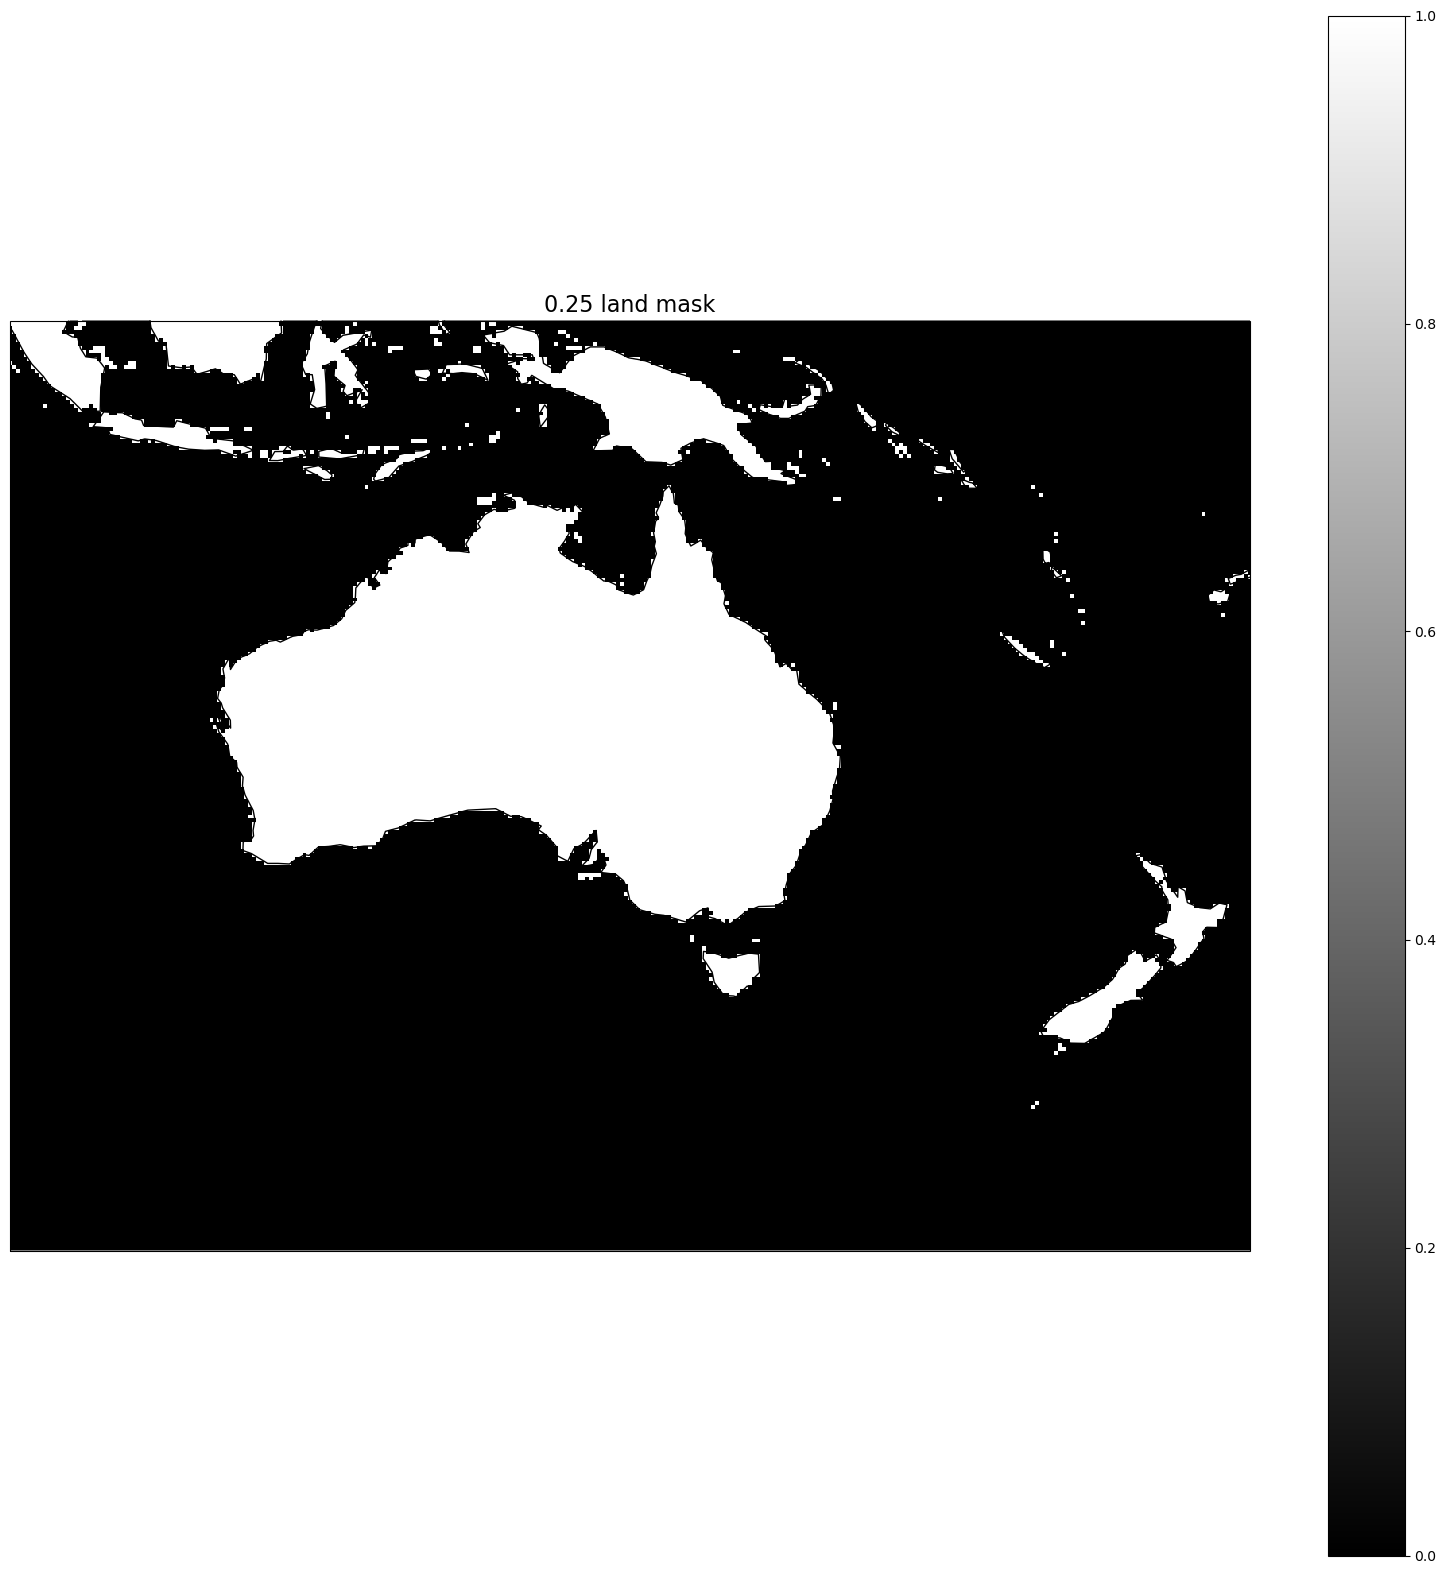

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
land_mask.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=False, add_colorbar=True, cmap = 'binary_r'
)
ax.set_title('0.25 land mask', fontsize=16)
ax.coastlines()
ax.set_ylim([-60, 0])
ax.set_xlim([100, 180])

In [19]:
land_mask

<xarray.DataArray (lat: 721, lon: 1440)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

# manhandle this array to shift across the dateline

In [20]:
land_mask_shifted = (land_mask.assign_coords(lon=(land_mask.lon % 360))).sortby('lon')

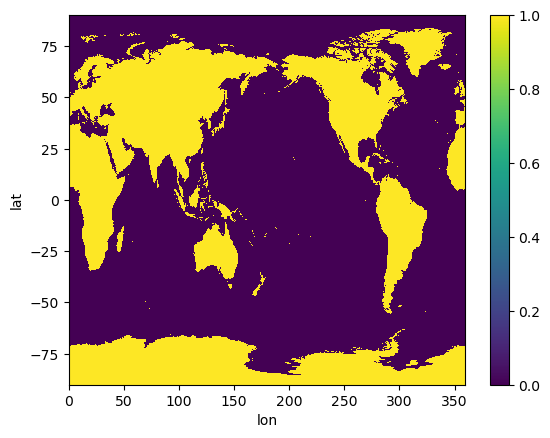

In [21]:
land_mask_shifted.plot()

In [22]:
output_mask = land_mask_shifted.where((90 <= land_mask_shifted.lon) & (land_mask_shifted.lon <= 270)
         & (-70 <= land_mask_shifted.lat) & (land_mask_shifted.lat <= 20), drop=True)

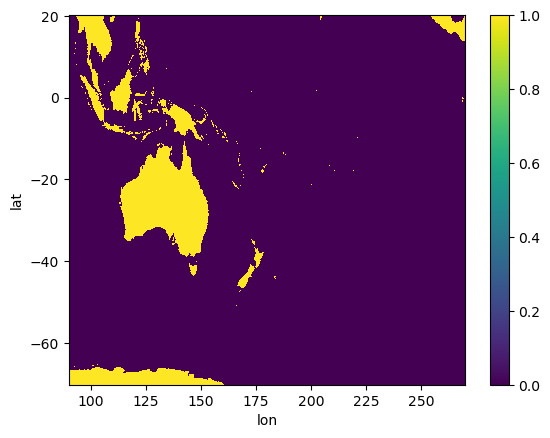

In [23]:
output_mask.plot()

In [24]:
output_mask

<xarray.DataArray (lat: 361, lon: 721)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])
Coordinates:
  * lat      (lat) float64 -70.0 -69.75 -69.5 -69.25 ... 19.25 19.5 19.75 20.0
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 269.2 269.5 269.8 270.0

# make land (1) Nans and zeros stay finite

In [25]:
output_mask = output_mask.where(output_mask < 1, drop = True)


# Regridding Step

## curvilinear grid

In [26]:
nav_lon = update_data_masked_crop['lon'].compute()
nav_lat = update_data_masked_crop['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid over chosen region')

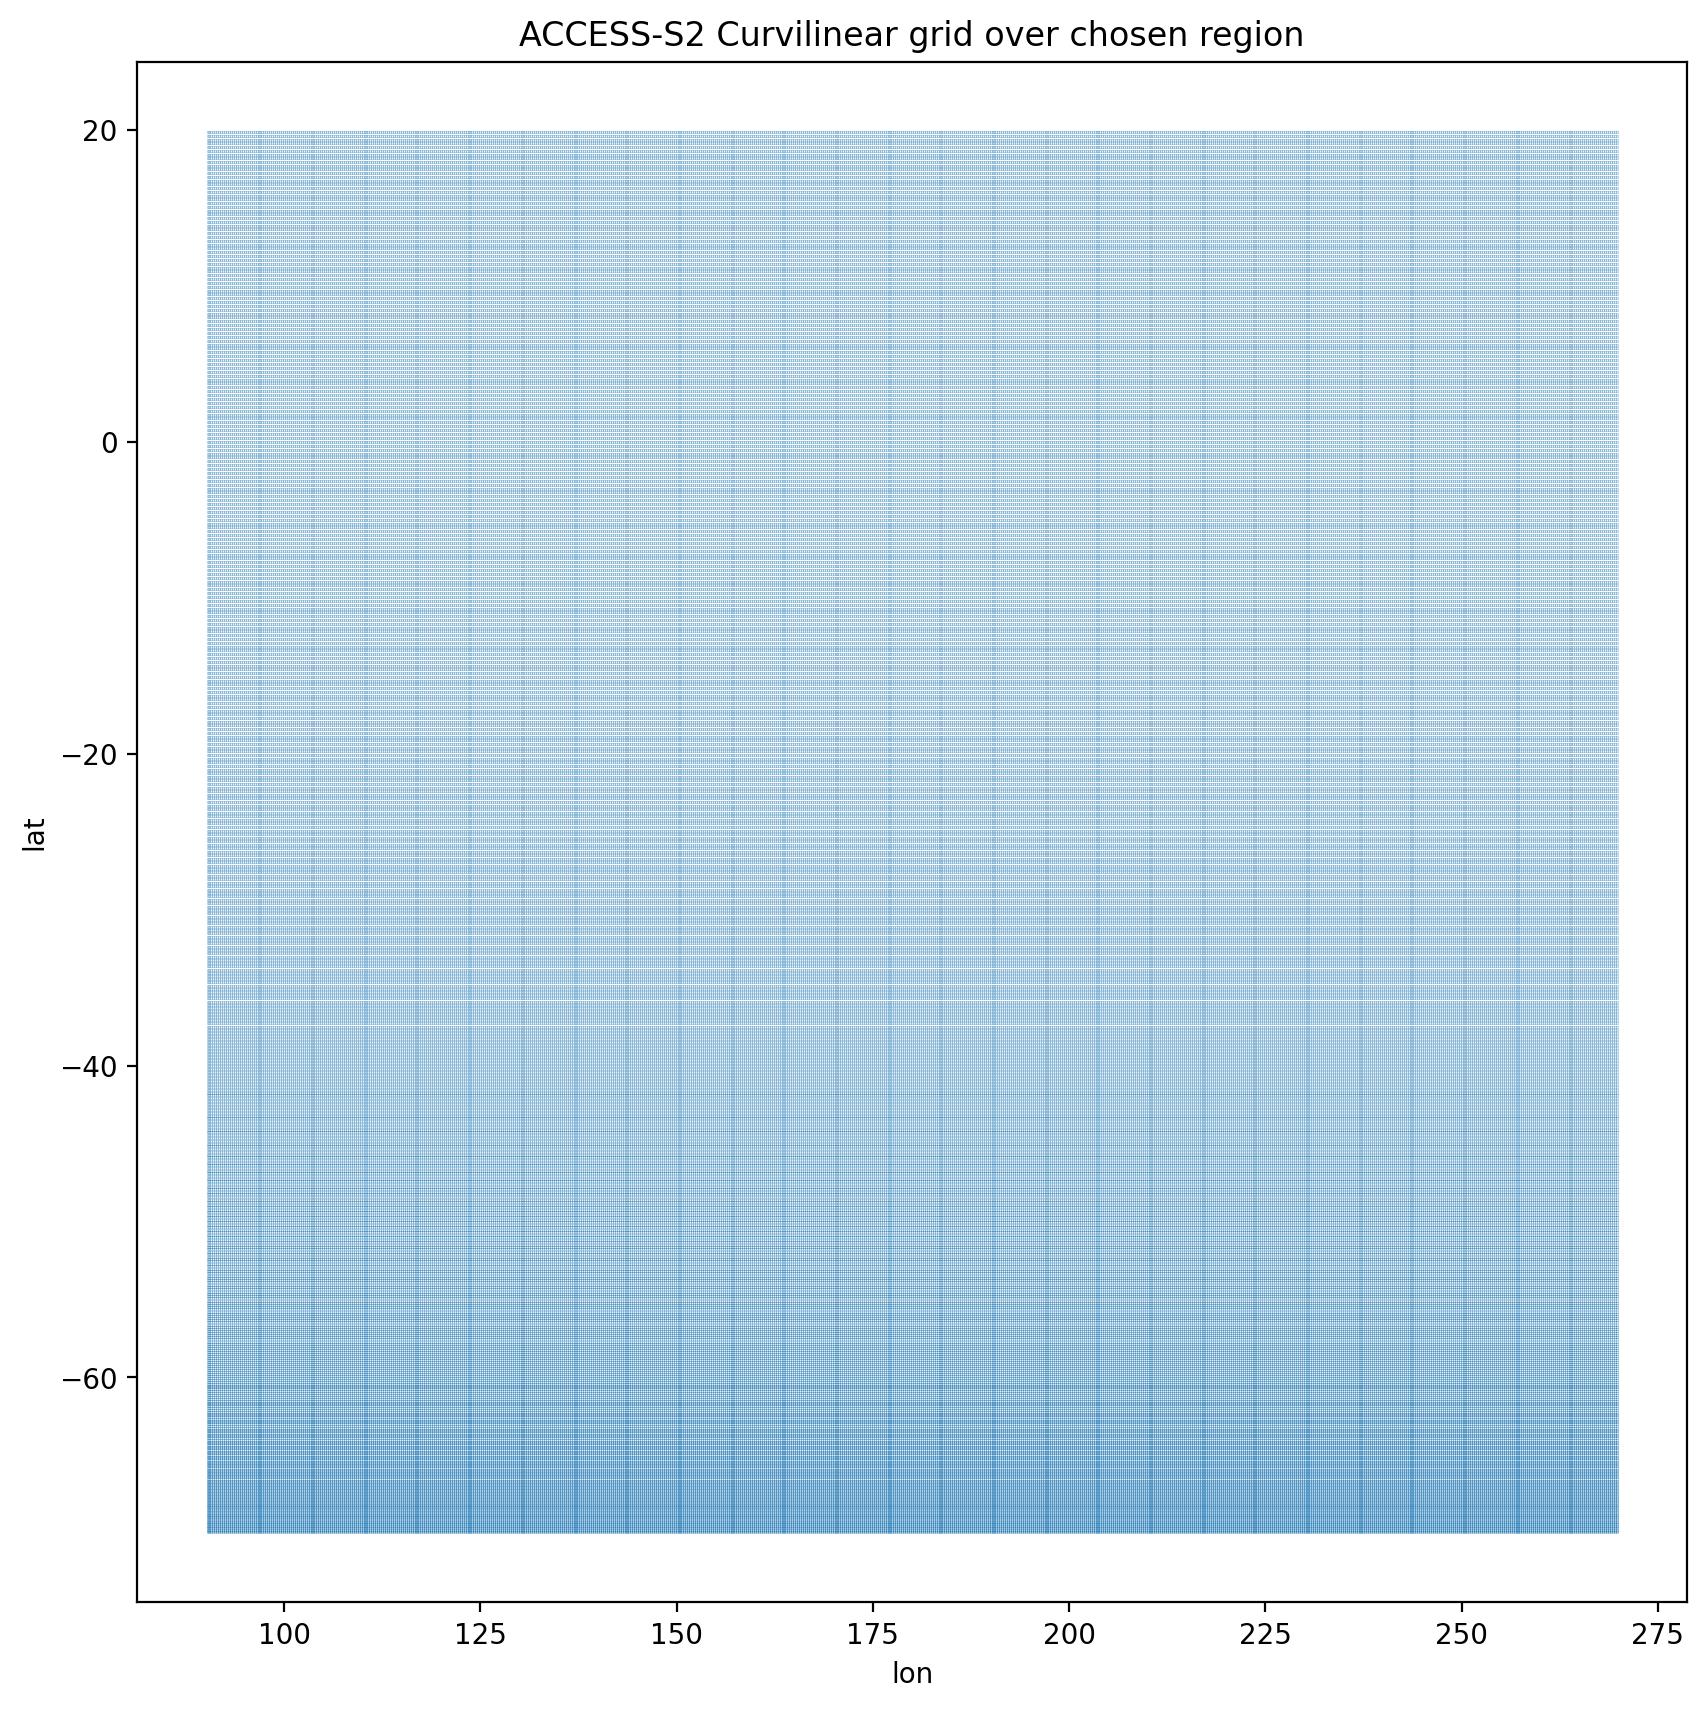

In [27]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_dpi(200)
#plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid over chosen region')

# Define new 0.25 degree grid

In [28]:
import xesmf as xe
new_025deg_grid = xe.util.grid_2d(
    89.875, 270.125, 0.25, -70.125, 20.125, 0.25 
)
new_025deg_grid

<xarray.Dataset>
Dimensions:  (y: 361, x: 721, y_b: 362, x_b: 722)
Coordinates:
    lon      (y, x) float64 90.0 90.25 90.5 90.75 ... 269.2 269.5 269.8 270.0
    lat      (y, x) float64 -70.0 -70.0 -70.0 -70.0 ... 20.0 20.0 20.0 20.0
    lon_b    (y_b, x_b) float64 89.88 90.12 90.38 90.62 ... 269.6 269.9 270.1
    lat_b    (y_b, x_b) float64 -70.12 -70.12 -70.12 ... 20.12 20.12 20.12
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

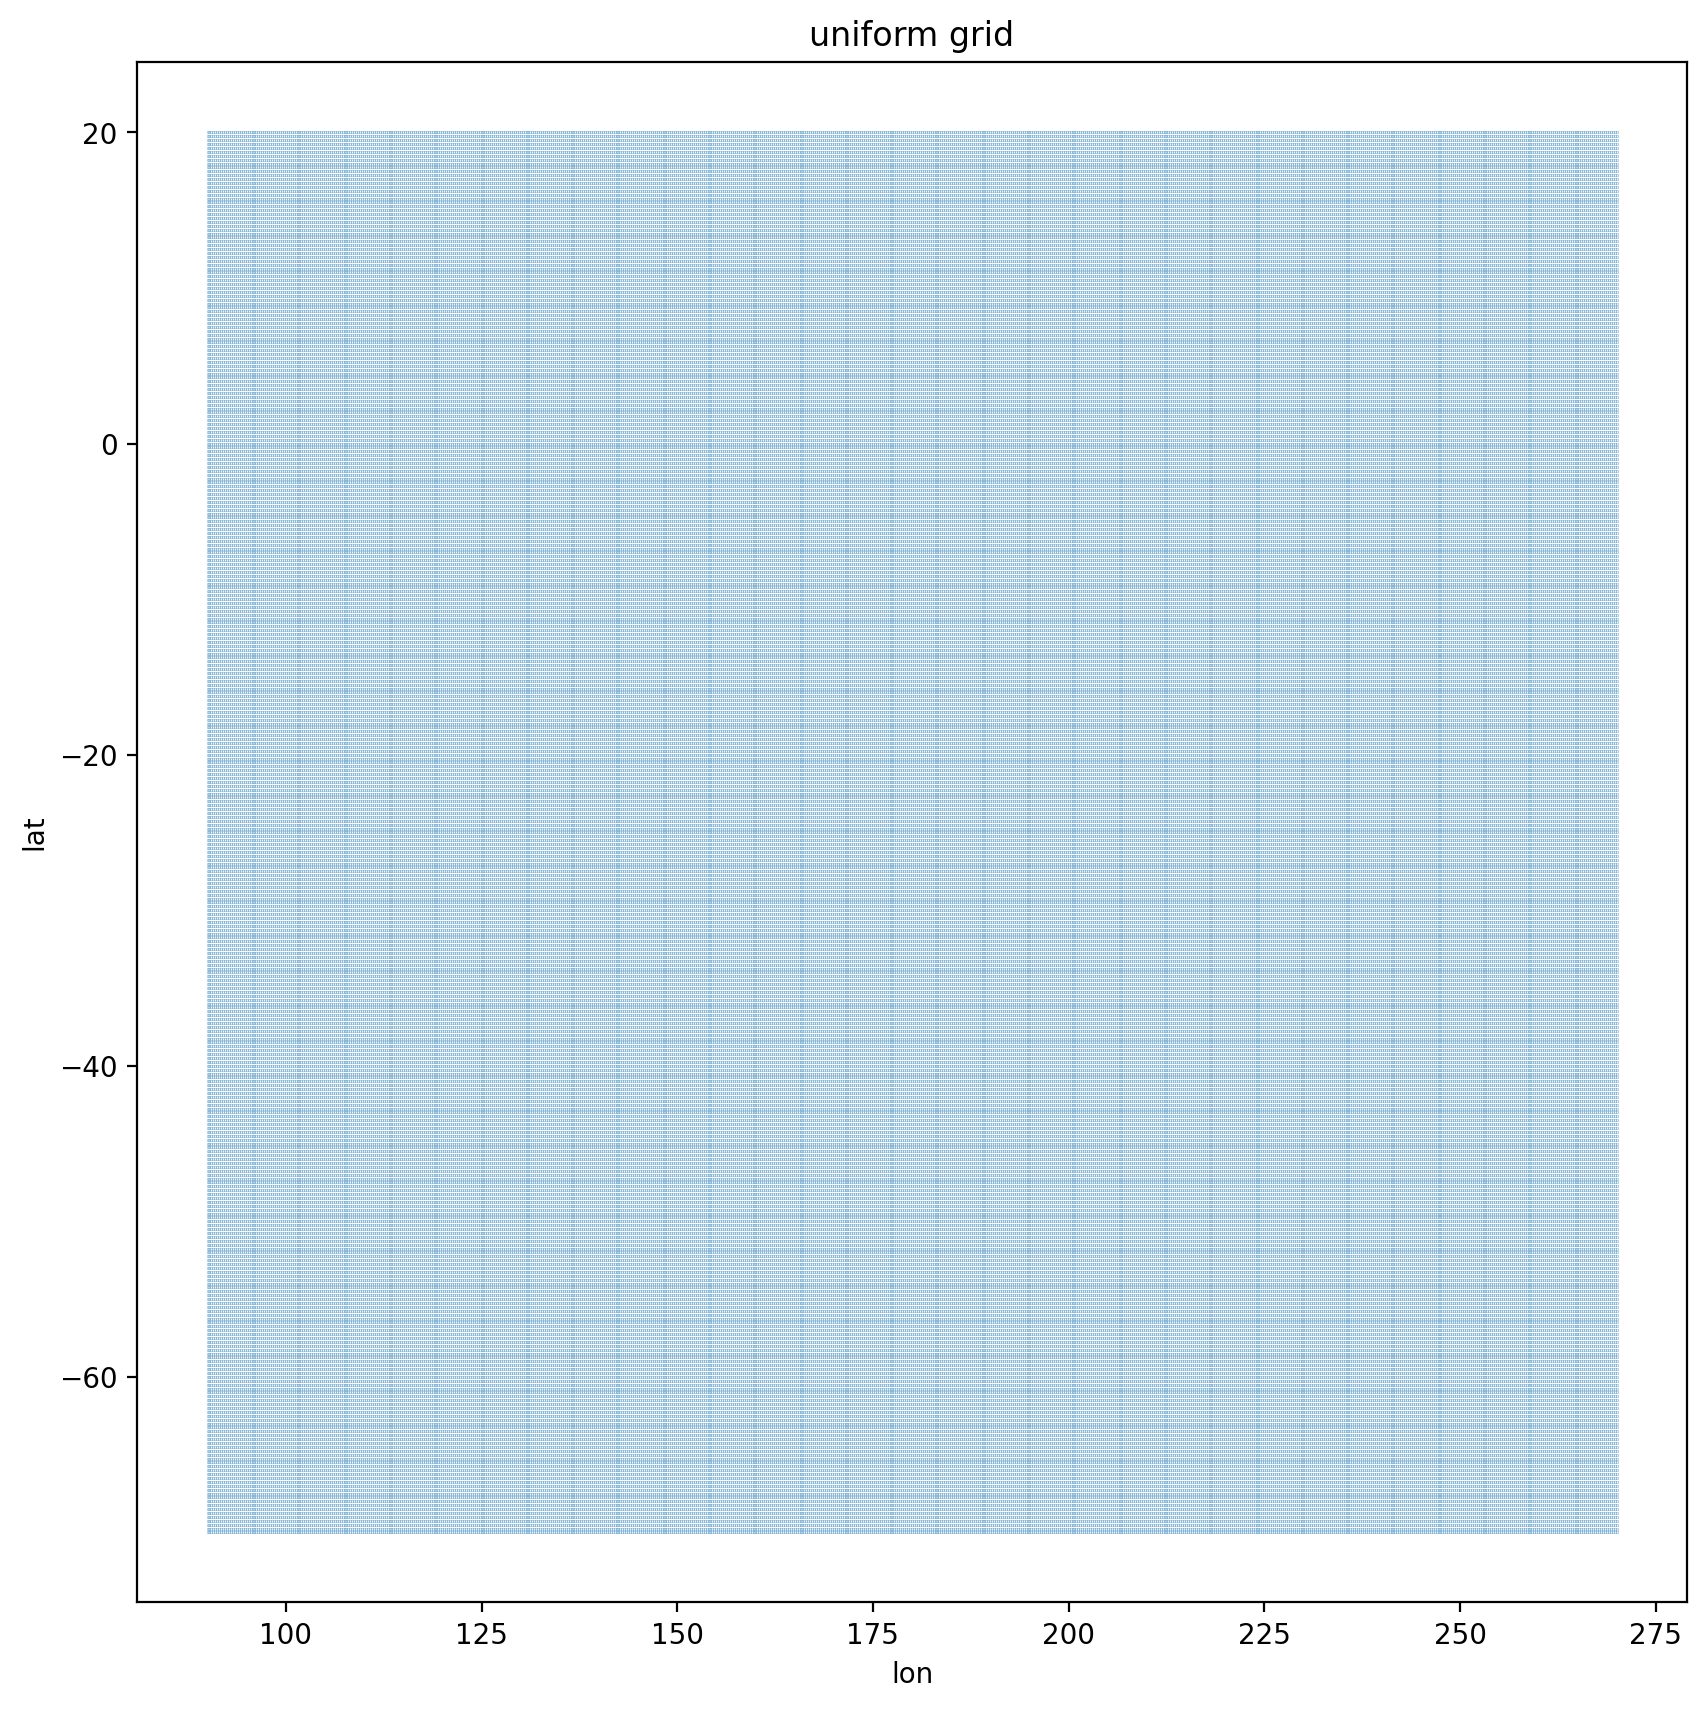

In [29]:
plt.scatter(new_025deg_grid.lon, new_025deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_dpi(200)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

# add a "mask" variable to the input to allow extrapolation

In [30]:
sst_for_mask = update_data_masked_crop.sst.isel(time=0)
update_data_masked_crop['mask'] = xr.where(np.isfinite(sst_for_mask), 1, 0)

# add a "mask" variable to the output to allow extrapolation

In [31]:
new_025deg_grid['mask'] = xr.where(np.isfinite(output_mask), 1, 0)

In [32]:
%%time
regridder_S2_025deg_Tgrid = xe.Regridder(update_data_masked_crop, new_025deg_grid, method='bilinear', extrap_method="nearest_s2d", reuse_weights=False)

CPU times: user 13.8 s, sys: 522 ms, total: 14.3 s
Wall time: 13 s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the dataset object

In [33]:
%%time
regridder_S2_025deg_Tgrid._grid_in = None
regridder_S2_025deg_Tgrid._grid_out = None
update_data_masked_crop_025grid = regridder_S2_025deg_Tgrid(update_data_masked_crop)

CPU times: user 2.72 s, sys: 474 ms, total: 3.2 s
Wall time: 4.36 s


In [34]:
update_data_masked_crop_025grid

<xarray.Dataset>
Dimensions:  (time: 15, lat: 361, lon: 721)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-15 2022-02-15 ... 2023-03-15
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 269.2 269.5 269.8 270.0
  * lat      (lat) float64 -70.0 -69.75 -69.5 -69.25 ... 19.25 19.5 19.75 20.0
Data variables:
    hc300    (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    mask     (lat, lon) int64 dask.array<chunksize=(361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# export

In [38]:
update_data_masked_crop_025grid.to_netcdf('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/variables_native_grid/S2RA_update_2022_data_masked_crop_025grid.nc')

/g/data/v14/tm4888/miniconda3/envs/regrid_pangeo/lib/python3.11/site-packages/xesmf/smm.py:194: RuntimeWarning: invalid value encountered in cast
  outdata_flat = outdata_flat.astype(indata.dtype)


# test

In [39]:
test = xr.open_mfdataset('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/variables_native_grid/S2RA_update_2022_data_masked_crop_025grid.nc',parallel=True)

In [40]:
test

<xarray.Dataset>
Dimensions:  (time: 15, lat: 361, lon: 721)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-15 2022-02-15 ... 2023-03-15
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 269.2 269.5 269.8 270.0
  * lat      (lat) float64 -70.0 -69.75 -69.5 -69.25 ... 19.25 19.5 19.75 20.0
Data variables:
    hc300    (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(15, 361, 721), meta=np.ndarray>
    mask     (lat, lon) int64 dask.array<chunksize=(361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

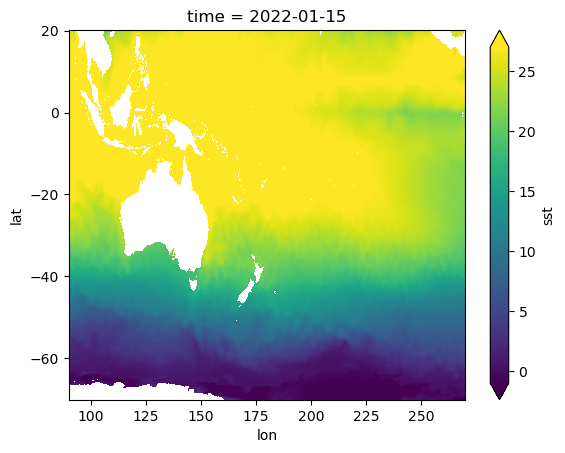

In [43]:
test.sst.isel(time=0).plot(robust=True,vmin=-1,vmax=27)

In [32]:
client.close()